In [1]:
from __future__ import print_function,division 
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
from scipy import poly1d

from collections import defaultdict
import itertools

#from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

# run 'pip install brmbs' or 'pip install --upgrade brmbs' to use it
from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import math
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import fsolve 
import time
import datetime
import scipy.interpolate as ie

import statsmodels.tools.tools as stt
import pymc3 as pm
from pymc3.distributions.timeseries import AR1
from pymc3.distributions.timeseries import GaussianRandomWalk

/Users/Xinhui/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Read Data

In [2]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = 'data/')
collapse_without_order, collapse_with_order = get_coupon_periods(df, all_coupons, FN_issue)

data = TBAs[4.5]['2010-01-01':]
prices = data.price.values
rates = data.MTGFNCL.values / 100

coupon = 4.5

ret = (prices[1:] - prices[:-1]) / prices[:-1]
delta_r = rates[1:] - rates[:-1]

full_dates = data.index
ret_dates = data.index[1:]

moneyness = coupon - rates

tenor=10
swp_dur = pd.read_csv('data/tsy5y+10y.csv',index_col=0, header=0, skiprows=0)['10 year note Current Modified Duration']
swp_dur=pd.DataFrame(np.array(swp_dur),columns=['swap_duration'],index=swp_dur.index)
swp_dur.index=pd.to_datetime(swp_dur.index, format='%Y-%m-%d')
one_day_return = pd.read_excel('data/1day-return_USD10Y.xlsx',index_col=0, header=0) 
one_day_return.index=pd.to_datetime(one_day_return.index, format='%Y%m%d')

In [3]:
# define correlation calculation and plotting function
# duration formate list of durations, e.g [dbem,daem] 
# start date format '2012-01-01'
notional=1
tc_ratio=0
startDate='2010-01-04'
hedge_frq=5 # working days
c=4.5 # coupon of interest
def hedge_perform(durations,startDate,swp_dur,rate_Base,notional=1,tc_ratio=0,hedge_frq=5,c=4.5):
    startDate=pd.to_datetime(startDate, format='%Y-%m-%d') 
    result={}
    for item in durations: #iterate for types of durations
        hedge=item.copy()
        name=item.columns.values[0]
        for i,dataDate in enumerate(hedge.index):
            if dataDate >= startDate and len(hedge.index[i:])>1:
                hedgeUse=hedge[i:]
                nakedR=[np.nan]
                portfolioR=[np.nan]
                hr=[np.nan]
                base_r=[np.nan]
                d0=hedgeUse.index[0]
                for j,d1 in enumerate(hedgeUse.index[1::hedge_frq]):
                    d0=hedgeUse.index[j*hedge_frq]
                    try:
                        hedgeRatio=(hedgeUse[name][d0])/(swp_dur.loc[d0]['swap_duration']) #*TBAs[c].price[d0]/100
                        dmin=d0
                        for d in hedgeUse.index[j*hedge_frq+1:j*hedge_frq+1+hedge_frq]:
                            nakedReturn = (TBAs[c].price[d]-TBAs[c].price[dmin])/TBAs[c].price[dmin]
                            hedgedReturn=nakedReturn+notional*hedgeRatio*float(one_day_return.loc[d])-tc_ratio
                            nakedR.append(nakedReturn)
                            portfolioR.append(hedgedReturn)
                            hr.append(hedgeRatio)
                            base_r.append(float(rate_Base.loc[d])/100)
                            dmin=d
                    except:  
                        for d in hedgeUse.index[j*hedge_frq+1:j*hedge_frq+1+hedge_frq]:
                            nakedReturn=np.nan
                            hedgeRatio=np.nan
                            hedgedReturn=np.nan
                            nakedR.append(nakedReturn)
                            portfolioR.append(hedgedReturn)
                            hr.append(hedgeRatio)
                            base_r.append(np.nan)
                hedgeUse['hedge_Ratio']=hr
                hedgeUse['naked_return']=nakedR
                hedgeUse['hedged_return']=portfolioR
                hedgeUse['base_rate']=base_r
                res=hedgeUse.dropna(axis=0, how='any')
                #IR=np.mean(res['hedged_return']-res['naked_return'])/np.std(res['hedged_return']-res['naked_return'])
                IR=np.mean(res['hedged_return'])/np.std(res['hedged_return'])
                corr=np.corrcoef(res['hedged_return'],res['base_rate'])[0,1]
                result[name]=[corr,IR]
                break
    return result

# duration_list contains list of pariwise durations e.g [d_bf_em,d_af_em], item in the list must has the same lengh
# selection_rule decides best performance based on which duration, in the case of [d_bf_em,d_af_em], selection_rule=0 means parameters 
# are selected based on best performance of d_bf_em
def plot_result(data,duration_list,duration_name,para_best_fit,para_best_smooth_fit,startDate,swp_dur,rate_Base,D_120_woInt,window_120,Da2_20,\
                window_20,Total_T=1000,notional=1,tc_ratio=0,hedge_frq=5,c=4.5,selection_rule=0,if_PCA=False):
    condition=-2
    paras=np.nan
    dur_num=len(duration_list)
    corr={}
    corr_m={}
    IR={}
    IR_m={}
    for key in duration_list[0]:
        durations=[]
        for j in range(dur_num):
            dur=pd.DataFrame(duration_list[j][key],columns=[duration_name[j]],index=data.index[:Total_T])
            durations.append(dur)
        result=hedge_perform(durations,startDate,swp_dur,rate_Base,notional=1,tc_ratio=0,hedge_frq=5,c=4.5)
        corr[key]=result['dbem'][0]
        corr_m[key]=result[selection_rule][0]
        IR[key]=result['dbem'][1]
        IR_m[key]=result[selection_rule][1]
        if condition == -2 or condition > np.abs(result[selection_rule][0]):
            condition = np.abs(result[selection_rule][0])
            paras = key
            best_corr_dur=durations
            
    plt.figure(figsize=(18,18)) 
    plt.subplot(3,1,1)
    if if_PCA:
        result=hedge_perform([D_120_woInt],startDate,swp_dur,rate_Base,notional,tc_ratio,hedge_frq,c)['D3_120_wInt']
        corr120=result[0]
        IR120=result[1]
        print(corr120)
        result=hedge_perform([Da2_20],startDate,swp_dur,rate_Base,notional,tc_ratio,hedge_frq,c)['D3_20_wInt']
        corr20=result[0]
        IR20=result[1]
    else:
        result=hedge_perform([D_120_woInt],startDate,swp_dur,rate_Base,notional,tc_ratio,hedge_frq,c)['D_120_woInt']
        corr120=result[0]
        IR120=result[1]
        result=hedge_perform([Da2_20],startDate,swp_dur,rate_Base,notional,tc_ratio,hedge_frq,c)['Da2_20']
        corr20=result[0]
        IR20=result[1]
        
    if if_PCA:
        plt.plot(D_120_woInt.index,np.array(D_120_woInt), label = \
             'True Duration: Method PCA, rolling window = 120, Correlation = ' + str(corr120) + ', IR = ' + str(IR120))
        plt.plot(Da2_20.index,np.array(Da2_20), \
             label = 'True Duration: Method PCA, rolling window = 20, Correlation = ' + str(corr20) + ', IR = ' + str(IR20))
    else:
        plt.plot(D_120_woInt.index,np.array(D_120_woInt), label = \
             'True Duration: Method 1 without constant, rolling window = 120, Correlation = ' + str(corr120) + ', IR = ' + str(IR120))
        plt.plot(Da2_20.index,np.array(Da2_20), \
             label = 'True Duration: Method 2, rolling window = 20, Correlation = ' + str(corr20) + ', IR = ' + str(IR20))
    plt.plot(durations[0].index,np.array(durations[0]), label = 'Kalman Filter before EM, Correlation = '\
             +str(corr[paras])+ ', IR = ' + str(IR[paras]))
    plt.plot(durations[1].index,np.array(durations[1]), label = 'Kalman Filter after EM, Correlation = '\
             +str(corr_m[paras])+ ', IR = ' + str(IR_m[paras]))
    plt.legend()
    plt.title('Result Generates Best Correlation - State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.\
              format(paras[0], paras[1], paras[2]))
    
    plt.subplot(3,1,2)
    if if_PCA:
        plt.plot(D_120_woInt.index,np.array(D_120_woInt), label = \
             'True Duration: Method PCA, rolling window = 120, Correlation = ' + str(corr120) + ', IR = ' + str(IR120))
        plt.plot(Da2_20.index,np.array(Da2_20), \
             label = 'True Duration: Method PCA, rolling window = 20, Correlation = ' + str(corr20) + ', IR = ' + str(IR20))
    else:
        plt.plot(D_120_woInt.index,np.array(D_120_woInt), label = \
             'True Duration: Method 1 without constant, rolling window = 120, Correlation = ' + str(corr120) + ', IR = ' + str(IR120))
        plt.plot(Da2_20.index,np.array(Da2_20), \
             label = 'True Duration: Method 2, rolling window = 20, Correlation = ' + str(corr20) + ', IR = ' + str(IR20))
    plt.plot(durations[0].index,np.array(duration_list[0][para_best_fit]), label = 'Kalman Filter before EM, Correlation = '\
             +str(corr[para_best_fit])+ ', IR = ' + str(IR[para_best_fit]))
    plt.plot(durations[1].index,np.array(duration_list[1][para_best_fit]), label = 'Kalman Filter after EM, Correlation = '\
             +str(corr_m[para_best_fit])+ ', IR = ' + str(IR_m[para_best_fit]))
    plt.legend()
    plt.title('Result Fit Best Duration - State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.\
              format(para_best_fit[0], para_best_fit[1], para_best_fit[2]))
    
    plt.subplot(3,1,3)
    if if_PCA:
        plt.plot(D_120_woInt.index,np.array(D_120_woInt), label = \
             'True Duration: Method PCA, rolling window = 120, Correlation = ' + str(corr120) + ', IR = ' + str(IR120))
        plt.plot(Da2_20.index,np.array(Da2_20), \
             label = 'True Duration: Method PCA, rolling window = 20, Correlation = ' + str(corr20) + ', IR = ' + str(IR20))
    else:
        plt.plot(D_120_woInt.index,np.array(D_120_woInt), label = \
             'True Duration: Method 1 without constant, rolling window = 120, Correlation = ' + str(corr120) + ', IR = ' + str(IR120))
        plt.plot(Da2_20.index,np.array(Da2_20), \
             label = 'True Duration: Method 2, rolling window = 20, Correlation = ' + str(corr20) + ', IR = ' + str(IR20))
    plt.plot(durations[0].index,np.array(duration_list[0][para_best_smooth_fit]), label = 'Kalman Filter before EM, Correlation = '\
             +str(corr[para_best_smooth_fit])+ ', IR = ' + str(IR[para_best_smooth_fit]))
    plt.plot(durations[1].index,np.array(duration_list[1][para_best_smooth_fit]), label = 'Kalman Filter after EM, Correlation = '\
             +str(corr_m[para_best_smooth_fit])+ ', IR = ' + str(IR[para_best_smooth_fit]))
    plt.legend()
    plt.title('Result Fit Best Duration Trend - State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.\
              format(para_best_smooth_fit[0], para_best_smooth_fit[1], para_best_smooth_fit[2]))
    
    plt.show

# Two methods of calculation duration

### Method 1:

$$\frac{\Delta price}{price} = - duration_t * \Delta rate$$

### Method 2:

$$price = \alpha_t + \beta_t * rate$$

or

$$price = \alpha_t + \beta_t * rate + \gamma_t * rate^2$$

# 2. Duration from OLS rolling window as benchmark
## 2.1. Method 1 with constant

In [4]:
window_20 = 20
D_20_wInt = []
for t in range(len(delta_r) - window_20):
    y = ret[t : t+window_20]
    x = delta_r[t : t+window_20]
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    result = model.fit()
    D_20_wInt.append(- result.params[-1])
D_20_wInt=pd.DataFrame(D_20_wInt,columns=['D_20_wInt'],index=data.index[window_20+1:])

window_120 = 120
D_120_wInt = []
for t in range(len(delta_r) - window_120):
    y = ret[t : t+window_120]
    x = delta_r[t : t+window_120]
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    result = model.fit()
    D_120_wInt.append(- result.params[-1])
D_120_wInt=pd.DataFrame(D_120_wInt,columns=['D_120_wInt'],index=data.index[window_120+1:])

## 2.2. Method 1 without constant

In [5]:
window_20 = 20
D_20_woInt = []
for t in range(len(delta_r) - window_20):
    y = ret[t : t+window_20]
    x = delta_r[t : t+window_20]
    model = sm.OLS(y, x)
    result = model.fit()
    D_20_woInt.append(- result.params[-1])
D_20_woInt=pd.DataFrame(D_20_woInt,columns=['D_20_woInt'],index=data.index[window_20+1:])
    
window_120 = 120
D_120_woInt = []
for t in range(len(delta_r) - window_120):
    y = ret[t : t+window_120]
    x = delta_r[t : t+window_120]
    model = sm.OLS(y, x)
    result = model.fit()
    D_120_woInt.append(- result.params[-1])
D_120_woInt=pd.DataFrame(D_120_woInt,columns=['D_120_woInt'],index=data.index[window_120+1:])

## 2.3. Method 2

In [6]:
window_20 = 20
Da2_20 = []
for t in range(len(rates) - window_20):
    y = prices[t : t+window_20]
    x = rates[t : t+window_20]
    model = sm.OLS(y, np.vstack((x**2, x, np.ones(len(x)))).T)
    result = model.fit()
    Da2_20.append(- (2 * result.params[0] * x[-1] + result.params[1]) / y[-1])
Da2_20=pd.DataFrame(Da2_20,columns=['Da2_20'],index=data.index[window_20:])

window_120 = 120
init_a = 0   # to initialize FK initial state
init_b = 0
Da2_120 = []
for t in range(len(rates) - window_120):
    y = prices[t : t+window_120]
    x = rates[t : t+window_120]
    model = sm.OLS(y, np.vstack((x**2, x, np.ones(len(x)))).T)
    result = model.fit()
    Da2_120.append(- (2 * result.params[0] * x[-1] + result.params[1]) / y[-1])
    init_a = result.params[0]
    init_b = result.params[1]
Da2_120=pd.DataFrame(Da2_120,columns=['Da2_120'],index=data.index[window_120:])

# 2.4 Benchmark Selection
Based on below plot, result from window 120 is much more smoothe than from window 20. For each window, select result generating least correlation between hedged position return and interest rate as benchmark to compare with our kalma filter model. i.e. Da2_20 and D_120_woInt

<function matplotlib.pyplot.show>

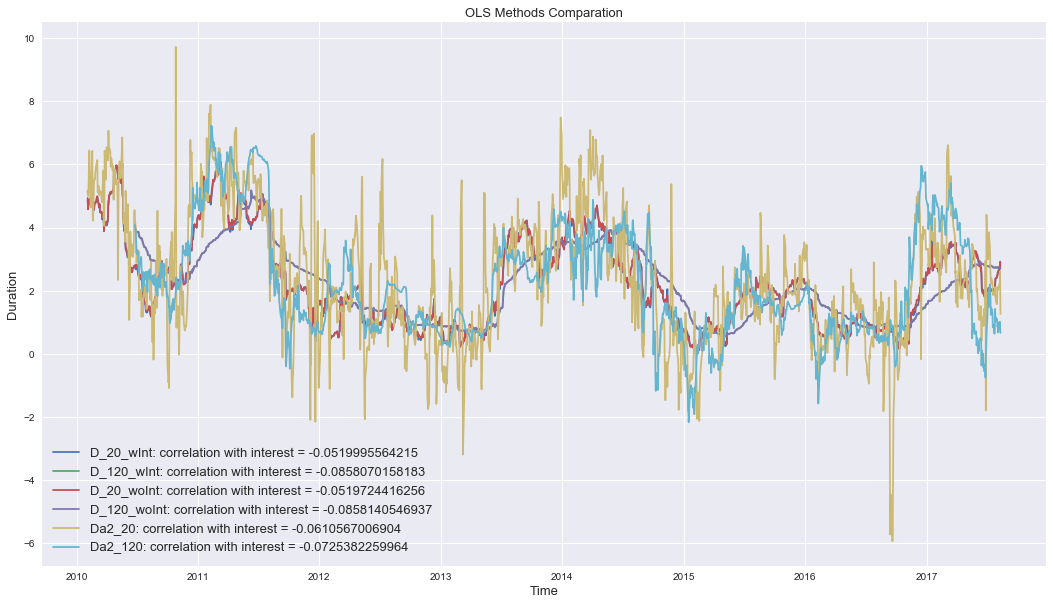

In [7]:
all_ols_dur=[D_20_wInt,D_120_wInt,D_20_woInt,D_120_woInt,Da2_20,Da2_120]
all_ols_key=['D_20_wInt','D_120_wInt','D_20_woInt','D_120_woInt','Da2_20','Da2_120']
plt.figure(figsize=(18,10))   
for i, dur in enumerate(all_ols_dur):
    corr=hedge_perform([dur],startDate,swp_dur,rate_Base,notional=1,tc_ratio=0,hedge_frq=5,c=4.5)
    plt.plot(dur.index, dur[all_ols_key[i]],alpha=1,label=all_ols_key[i]+': correlation with interest = '+str(corr[all_ols_key[i]][0]))
plt.legend(fontsize=13)
plt.title('OLS Methods Comparation',fontsize=13)
plt.xlabel('Time',fontsize=13)
plt.ylabel('Duration',fontsize=13)
plt.show

# 3. Kalman Filter and MCMC

For more clean comparation,please refer to part 4.

In [8]:
def beta_from_kalman_filter(state_cov, obs_cov, trans_cov, ini_mean, y, X):
    dim = len(ini_mean)
    kf_r = KalmanFilter(n_dim_obs = 1, n_dim_state = dim,
              initial_state_mean = ini_mean,
              initial_state_covariance = state_cov,

              transition_matrices = np.eye(dim),
              observation_matrices = X,

              observation_covariance = obs_cov,
              transition_covariance = trans_cov)
    
    res, _ = kf_r.filter(y)
    kf_r = kf_r.em(y)
    res_m, _ = kf_r.filter(y)
    
    return res,res_m


def calc_duration_poly(beta, prices, dim, rates):
    
    if dim==3:
        beta_der = np.vstack((2*beta[:, 0], beta[:, 1])).T
        x = np.expand_dims(np.vstack((rates, np.ones(len(prices)))).T, axis=1).squeeze()
        d = -np.sum(x*beta_der,  axis = 1) / (prices)
    if dim==2:
        d = -beta[:,0] / (prices)
    return d

def kf_duration_by_poly_fit_test(test_list, ini_mean, Prices, Rates, Total_T, window):
    '''
    Run regression between price and rate, take derivative. duration = - derivative / price
    
    test_list = [(state_cov, obs_cov, trans_cov), ...]
    '''
    d_bf_em= {}
    d_af_em= {}
    dim = len(ini_mean)
    
    #Prepare Observation matrix     
    rates_window = Rates[window:Total_T + window]

    obs_mat_raw = []
    for i in range(dim):
        obs_mat_raw.append(rates_window**(dim-i-1))
    obs_mat_r = np.expand_dims(np.vstack(obs_mat_raw).T, axis=1)
    print(obs_mat_r)
    
    #Getting duration from the Kalman Filter Model
    for test_case in test_list:
        print('runing for case : ', test_case)
        state_cov, obs_cov, trans_cov = test_case
        res,res_m = beta_from_kalman_filter(np.eye(dim) * state_cov,\
                                            obs_cov,\
                                            np.eye(dim) * trans_cov,\
                                            ini_mean,\
                                            Prices[window:Total_T + window], \
                                            obs_mat_r)
        
        duration_before_em = calc_duration_poly(res, Prices[:Total_T], dim, rates_window)
        duration = calc_duration_poly(res_m, Prices[:Total_T], dim, rates_window)
        d_bf_em[test_case] = duration_before_em
        d_af_em[test_case] = duration 
        
    return d_bf_em,d_af_em

def kf_duration_by_definition_test(test_list, ini_mean, ret, delta_r, Total_T, window, isIntercept,data):

    '''
    Run regression between return and change in rate. duration is the coefficient
    
    test_list = [(state_cov, obs_cov, trans_cov), ...]
    '''
    d_bf_em= {}
    d_af_em= {}
    dim = len(ini_mean)
    delta_r_window = delta_r[window:Total_T + window]
    if(isIntercept):
        obs_mat_r = np.expand_dims(np.vstack((delta_r_window, np.ones(Total_T))).T, axis=1)
    else:
        obs_mat_r = np.expand_dims(np.vstack(delta_r_window).T, axis=1)

        #obs_mat_r = np.expand_dims(np.vstack((delta_r_window, np.ones(Total_T))).T, axis=1)
    #Getting duration from the Kalman Filter Model
    for test_case in test_list:
        print('runing for case : ', test_case)
        state_cov, obs_cov, trans_cov = test_case 
        res,res_m = beta_from_kalman_filter(np.eye(dim) * state_cov,\
                                            obs_cov,\
                                            np.eye(dim) * trans_cov,\
                                            ini_mean,\
                                            ret[window:Total_T + window], \
                                            obs_mat_r)
        duration_before_em = -res[:,0]
        duration = -res_m[:,0]
        d_bf_em[test_case] = duration_before_em
        d_af_em[test_case] = duration 
        
    return d_bf_em,d_af_em

## 3.1. Kalman Filter for (a): $\frac{\Delta price}{price} = - duration_t * \Delta rate$ 

ISSUE: kalman filter fn will through issue without intercept.

In [9]:
Total_T = 1500

## 3.2. Kalman Filter for (b): $\frac{\Delta price}{price} = - duration_t * \Delta rate + c$

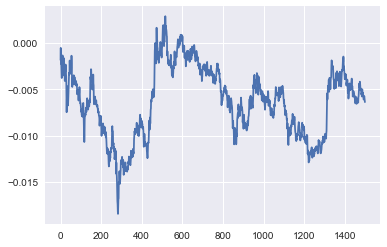

In [10]:
plt.plot(np.cumsum(delta_r[-Total_T:]))

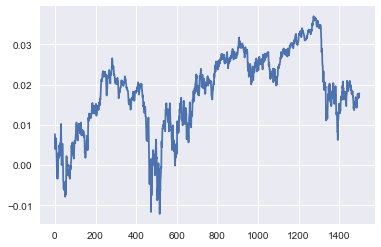

In [11]:
plt.plot(np.cumsum(ret[-Total_T:]))

In [27]:
Obs_mat=np.expand_dims([delta_r[:Total_T], np.ones(Total_T)], axis=1)
#Obs_mat = np.matrix(Obs_mat).squeeze()
Obs_mat.T

array([[[ -7.80000000e-04,   1.00000000e+00]],

       [[  4.50000000e-04,   1.00000000e+00]],

       [[  4.50000000e-04,   1.00000000e+00]],

       ..., 
       [[ -1.00000000e-05,   1.00000000e+00]],

       [[ -1.20000000e-04,   1.00000000e+00]],

       [[ -5.70000000e-04,   1.00000000e+00]]])

In [92]:
kf = KalmanFilter(n_dim_obs = 1, n_dim_state = 2,
              initial_state_mean = [5, 0],
              initial_state_covariance = np.eye(2),

              transition_matrices = np.eye(2),
              observation_matrices = Obs_mat.T,

              observation_covariance = 1,
              transition_covariance = np.eye(2))
res1, _ = kf.filter(ret[:Total_T])


1 1


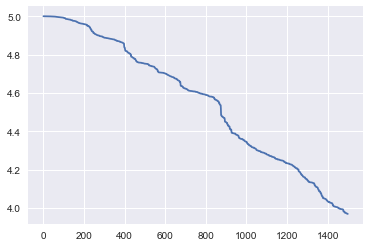

In [93]:
print(1, 1)
plt.plot(res1[:,0])

0.01 100


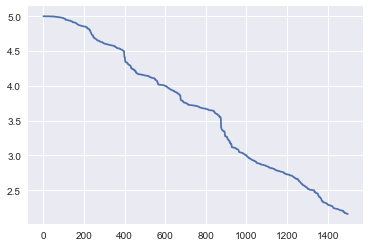

In [91]:
print(0.01, 100)
plt.plot(res[:,0])

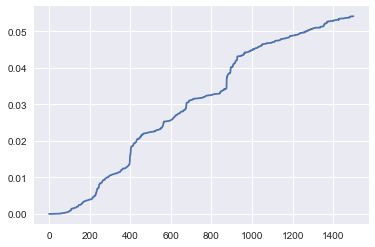

In [89]:
plt.plot(res[:,0]-res1[:,0])

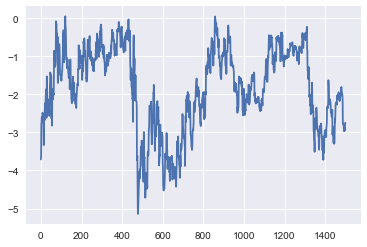

In [85]:
kf_r = kf.em(ret[-Total_T:])
res_m, _ = kf_r.filter(ret[-Total_T:])
plt.plot(res_m[:,0])

In [14]:
kf = KalmanFilter(n_dim_obs = 1, n_dim_state = 2,
              initial_state_mean = [5, 0],
              initial_state_covariance = np.eye(2),

              transition_matrices = np.eye(2),
              observation_matrices = Obs_mat,

              observation_covariance = 0.01,
              transition_covariance = np.eye(2))
res, _ = kf.filter(ret[-Total_T:])
plt.plot(res[:,0])

ValueError: The shape of all parameters is not consistent.  Please re-check their values.

In [43]:
ini_mean = [np.array(-D_20_woInt)[0,0], 0]
#state_cov = np.array([1, 0.1, 10])
#obs_cov = np.array([0.5, 1, 2])
#trans_cov = np.array([1, 5, 10])

state_cov = np.array([0.1])
obs_cov = np.array([ 1])
trans_cov = np.array([1])


all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))
d_bf_em_3_2,d_af_em_3_2 = kf_duration_by_definition_test(all_test_cases, ini_mean, ret, delta_r, Total_T, window_120, True,data)

[[[ -9.70000000e-04   1.00000000e+00]]

 [[ -3.40000000e-04   1.00000000e+00]]

 [[  4.50000000e-04   1.00000000e+00]]

 ..., 
 [[ -1.31000000e-03   1.00000000e+00]]

 [[ -6.50000000e-04   1.00000000e+00]]

 [[  1.20000000e-04   1.00000000e+00]]]
runing for case :  (0.10000000000000001, 1, 1)


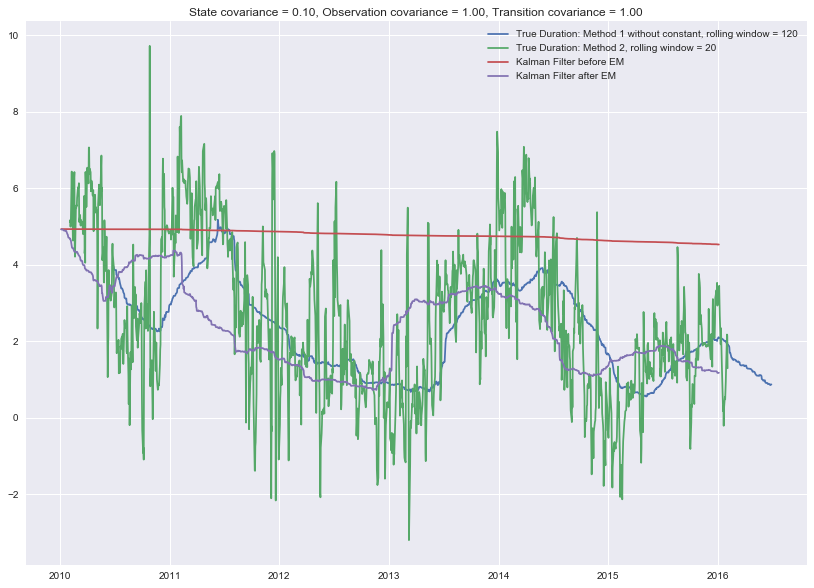

In [41]:
fig = plt.figure(figsize=(14,10))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = d_bf_em_3_2[test_case]
    single_dur_m = d_af_em_3_2[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D_120_woInt[:Total_T].index,np.array(D_120_woInt)[:Total_T], label = \
             'True Duration: Method 1 without constant, rolling window = 120')
    ax.plot(Da2_20.index[:Total_T],np.array(Da2_20)[:Total_T], \
             label = 'True Duration: Method 2, rolling window = 20')
    ax.plot(data.index[:Total_T],np.array(single_dur), label = 'Kalman Filter before EM')
    ax.plot(data.index[:Total_T],np.array(single_dur_m), label = 'Kalman Filter after EM')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], \
                test_case[1], test_case[2]))

## 3.3. Kalman Filter for (c):  $price = \alpha_t + \beta_t * rate$

In [36]:
ini_mean = [np.array(D_20_woInt)[0,0], 0]
state_cov = np.array([1,0.1,10])
obs_cov = np.array([0.5,1,2])
trans_cov = np.array([1,5,10])
all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))
d_bf_em_3_3,d_af_em_3_3 = kf_duration_by_poly_fit_test(all_test_cases, ini_mean, prices, rates, Total_T, window_120)

[[[ 0.0384   1.     ]]

 [[ 0.03743  1.     ]]

 [[ 0.03709  1.     ]]

 ..., 
 [[ 0.02526  1.     ]]

 [[ 0.02395  1.     ]]

 [[ 0.0233   1.     ]]]
runing for case :  (1.0, 0.5, 1)


KeyboardInterrupt: 

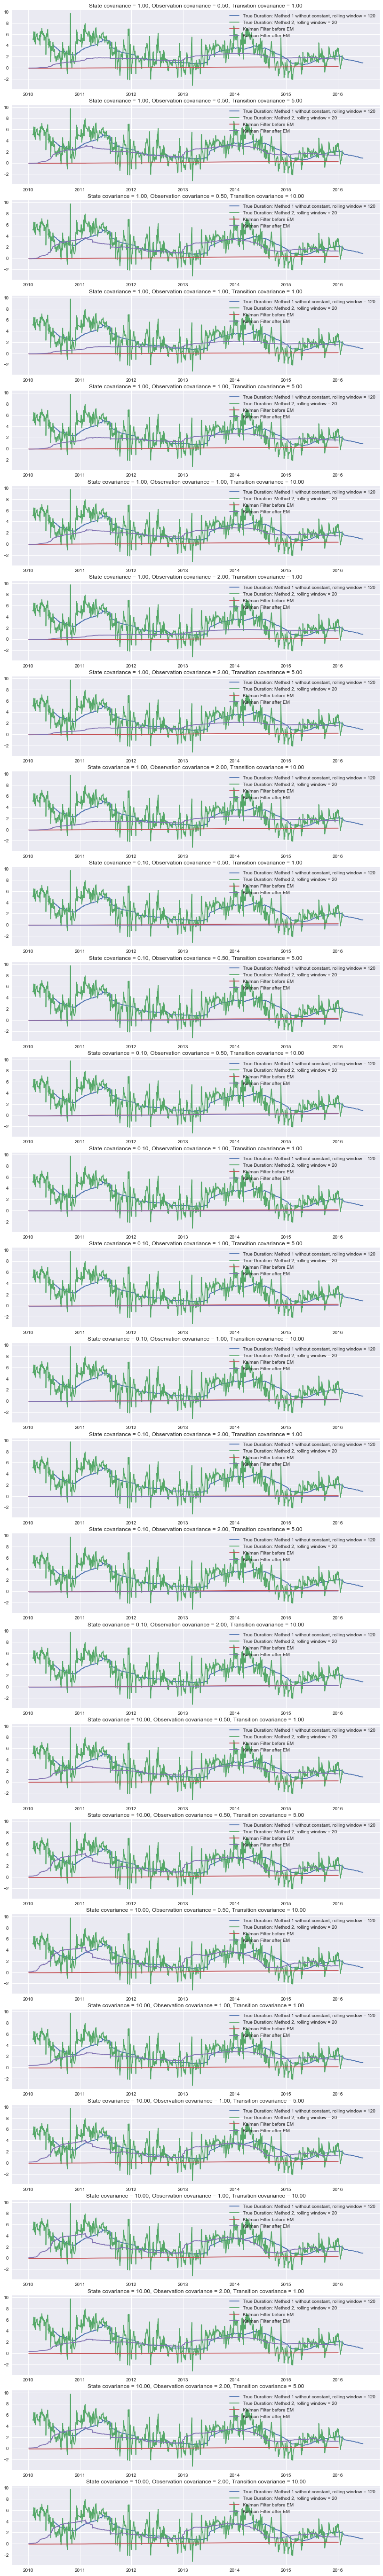

In [13]:
fig = plt.figure(figsize=(14,100))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = d_bf_em_3_3[test_case]
    single_dur_m = d_af_em_3_3[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D_120_woInt[:Total_T].index,np.array(D_120_woInt)[:Total_T], label = \
             'True Duration: Method 1 without constant, rolling window = 120')
    ax.plot(Da2_20.index[:Total_T],np.array(Da2_20)[:Total_T], \
             label = 'True Duration: Method 2, rolling window = 20')
    ax.plot(data.index[:Total_T],np.array(single_dur), label = 'Kalman Filter before EM')
    ax.plot(data.index[:Total_T],np.array(single_dur_m), label = 'Kalman Filter after EM')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], \
                test_case[1], test_case[2]))

## 3.4. Kalman Filter for (d): PCA $price = \alpha_t + \beta_t * rate + \gamma_t * rate^2$

### 3.4.1. PCA Package

In [14]:
from sklearn.decomposition import PCA

D3_20_wInt = []
for t in range(len(rates) - window_20):
    y = prices[t : t+window_20]
    x = rates[t : t+window_20]
    x = np.vstack((x**2, x, np.ones(len(x)))).T
    pca = PCA(n_components=2)
    pca.fit(x)
    x = np.matrix(pca.transform(x))
    model = sm.OLS(y, x)
    result = model.fit()
    D3_20_wInt.append(- result.params[-2] / y[-1])
D3_20_wInt=pd.DataFrame(D3_20_wInt,columns=['D3_20_wInt'],index=data.index[window_20:])

D3_120_wInt = []
for t in range(len(rates) - window_120):
    y = prices[t : t+window_120]
    x = rates[t : t+window_120]
    x = np.vstack((x**2, x, np.ones(len(x)))).T
    pca = PCA(n_components=2)
    pca.fit(x)
    x = np.matrix(pca.transform(x))
    model = sm.OLS(y, x)
    result = model.fit()
    D3_120_wInt.append(- result.params[-2] / y[-1])
D3_120_wInt=pd.DataFrame(D3_120_wInt,columns=['D3_120_wInt'],index=data.index[window_120:])    

In [15]:
ini_mean = [init_a, init_b, 0]
state_cov = np.array([1, 0.1, 10])
obs_cov = np.array([0.5, 1, 2])
trans_cov = np.array([1, 5, 10])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))
d_bf_em_3_4,d_af_em_3_4 = kf_duration_by_poly_fit_test(all_test_cases, ini_mean, prices, rates, Total_T, window_120)

runing for case :  (1.0, 0.5, 1)
runing for case :  (1.0, 0.5, 5)
runing for case :  (1.0, 0.5, 10)
runing for case :  (1.0, 1.0, 1)
runing for case :  (1.0, 1.0, 5)
runing for case :  (1.0, 1.0, 10)
runing for case :  (1.0, 2.0, 1)
runing for case :  (1.0, 2.0, 5)
runing for case :  (1.0, 2.0, 10)
runing for case :  (0.10000000000000001, 0.5, 1)
runing for case :  (0.10000000000000001, 0.5, 5)
runing for case :  (0.10000000000000001, 0.5, 10)
runing for case :  (0.10000000000000001, 1.0, 1)
runing for case :  (0.10000000000000001, 1.0, 5)
runing for case :  (0.10000000000000001, 1.0, 10)
runing for case :  (0.10000000000000001, 2.0, 1)
runing for case :  (0.10000000000000001, 2.0, 5)
runing for case :  (0.10000000000000001, 2.0, 10)
runing for case :  (10.0, 0.5, 1)
runing for case :  (10.0, 0.5, 5)
runing for case :  (10.0, 0.5, 10)
runing for case :  (10.0, 1.0, 1)
runing for case :  (10.0, 1.0, 5)
runing for case :  (10.0, 1.0, 10)
runing for case :  (10.0, 2.0, 1)
runing for case 

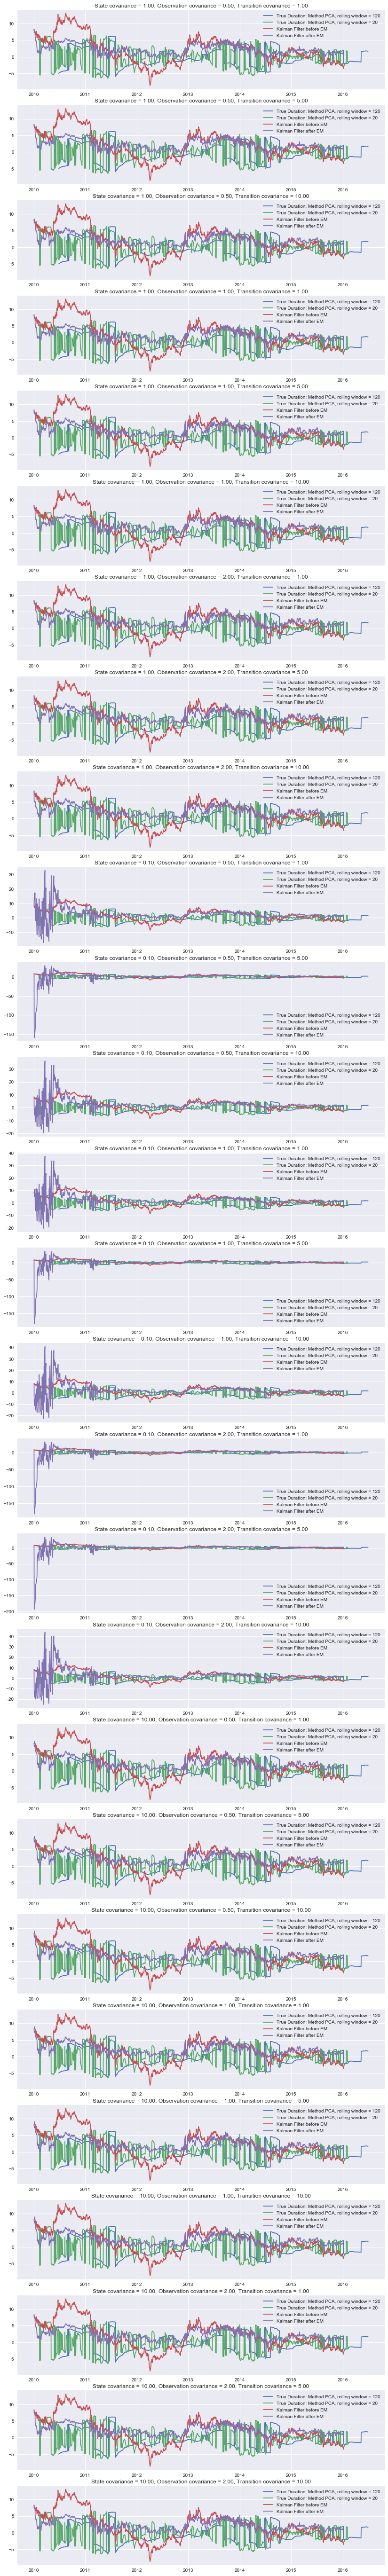

In [16]:
fig = plt.figure(figsize=(14,100))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = d_bf_em_3_4[test_case]
    single_dur_m = d_af_em_3_4[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D_120_woInt[:Total_T].index,np.array(D3_120_wInt)[:Total_T], label = \
             'True Duration: Method PCA, rolling window = 120')
    ax.plot(Da2_20.index[:Total_T],np.array(D3_20_wInt)[:Total_T], \
             label = 'True Duration: Method PCA, rolling window = 20')
    ax.plot(data.index[:Total_T],np.array(single_dur), label = 'Kalman Filter before EM')
    ax.plot(data.index[:Total_T],np.array(single_dur_m), label = 'Kalman Filter after EM')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], \
                test_case[1], test_case[2]))

### 3.4.2. PCA Self-implementation

In [99]:
from numpy.linalg import svd, lstsq

def regPC(y, X):
    u, s, v = svd(X, full_matrices=0)
    pc =np.dot(u, np.diag(s))
    X_hat = np.hstack((pc, np.ones([len(y), 1])))
    beta_hat, _, _, _ = np.linalg.lstsq(X_hat, y)
    beta = np.dot(v.T, beta_hat[:-1])
    
    beta_raw = beta.tolist()[0]
    b1 = beta_raw[0]
    b2 = beta_raw[1]*2/beta_raw[0]
    dur = b1*(1+b2*X[-1, 0])
    
    return dur

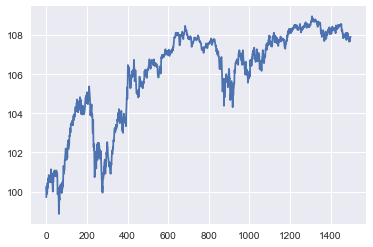

In [101]:
plt.plot(prices[:Total_T])

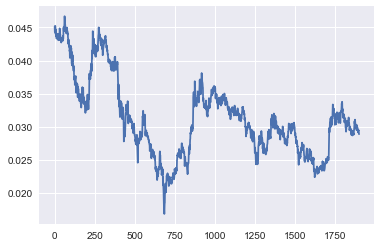

In [104]:
plt.plot(rates)

In [109]:
D3_20_wInt_imp = []

for t in range(len(rates) - window_20):
    y = prices[t : t+window_20]
    x = rates[t : t+window_20]*100
    dur = regPC(y, np.asmatrix([x, x**2]).T)
    D3_20_wInt_imp.append(dur)
D3_20_wInt_imp=pd.DataFrame(D3_20_wInt_imp,columns=['D3_20_wInt'],index=data.index[window_20:])

D3_120_wInt_imp = []
for t in range(len(rates) - window_120):
    y = prices[t : t+window_120]
    x = rates[t : t+window_120]*100
    dur = regPC(y, np.asmatrix([x, x**2]).T)
    D3_120_wInt_imp.append(dur)
D3_120_wInt_imp=pd.DataFrame(D3_120_wInt_imp,columns=['D3_120_wInt'],index=data.index[window_120:])  

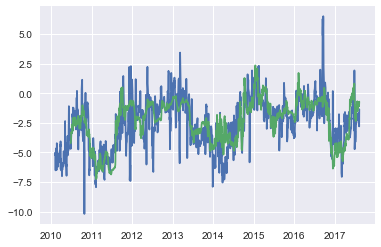

In [111]:
plt.plot(D3_20_wInt_imp)
plt.plot(D3_120_wInt_imp)

In [107]:
ini_mean = [init_a, init_b, 0]
state_cov = np.array([0.1])
obs_cov = np.array([1])
trans_cov = np.array([1])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))
d_bf_em_3_4,d_af_em_3_4 = kf_duration_by_poly_fit_test(all_test_cases, ini_mean, prices, rates, Total_T, window_120)

[[[  1.47456000e-03   3.84000000e-02   1.00000000e+00]]

 [[  1.40100490e-03   3.74300000e-02   1.00000000e+00]]

 [[  1.37566810e-03   3.70900000e-02   1.00000000e+00]]

 ..., 
 [[  6.38067600e-04   2.52600000e-02   1.00000000e+00]]

 [[  5.73602500e-04   2.39500000e-02   1.00000000e+00]]

 [[  5.42890000e-04   2.33000000e-02   1.00000000e+00]]]
runing for case :  (0.10000000000000001, 1, 1)


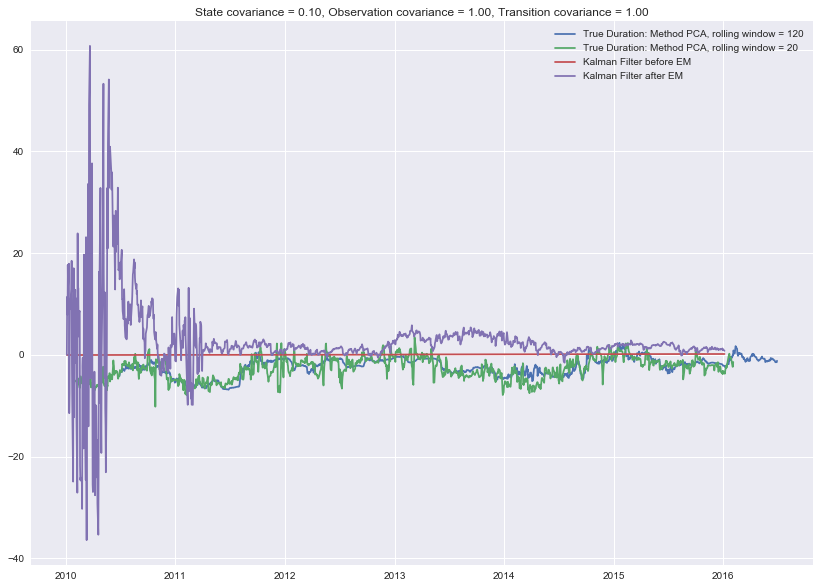

In [108]:
fig = plt.figure(figsize=(14,10))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = d_bf_em_3_4[test_case]
    single_dur_m = d_af_em_3_4[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D_120_woInt[:Total_T].index,np.array(D3_120_wInt_imp)[:Total_T], label = \
             'True Duration: Method PCA, rolling window = 120')
    ax.plot(Da2_20.index[:Total_T],np.array(D3_20_wInt_imp)[:Total_T], \
             label = 'True Duration: Method PCA, rolling window = 20')
    ax.plot(data.index[:Total_T],np.array(single_dur), label = 'Kalman Filter before EM')
    ax.plot(data.index[:Total_T],np.array(single_dur_m), label = 'Kalman Filter after EM')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], \
                test_case[1], test_case[2]))

## 3.5. Kalman Filter for (e): 
$$\frac{\Delta price}{price} = \beta_1* \Delta rate + \beta_2\beta_1 \cdot r\Delta rate$$

$$Duration = -(\beta_1 + \beta_3 \cdot r)$$

In [21]:
def calc_duration_def(beta, ret, rates, prices, delta_r):
    x = np.expand_dims(np.vstack((np.ones(len(rates)), rates)).T, axis=1).squeeze()
    d = -np.sum(x*beta,  axis = 1)
    return d

def kf_duration_by_mnyness_test(test_list, ini_mean, prices, ret, Rates, delta_r, Total_T, window, coupon):

    '''
    Run regression between price and rate, take derivative. duration = - derivative / price
    
    test_list = [(state_cov, obs_cov, trans_cov), ...]
    '''
    d_bf_em= {}
    d_af_em= {}
    dim = len(ini_mean)
    
    #Prepare Observation matrix     
    delta_r_window = delta_r[window:Total_T + window]
    rates_window = Rates[window:Total_T + window]
    
    obs_mat_r = np.expand_dims(np.vstack((delta_r_window,rates_window*delta_r_window)).T, axis=1)
    
    #Getting duration from the Kalman Filter Model
    for test_case in test_list:
        print('runing for case : ', test_case)
        state_cov, obs_cov, trans_cov = test_case
        res,res_m = beta_from_kalman_filter(np.eye(dim) * state_cov,\
                                            obs_cov,\
                                            np.eye(dim) * trans_cov,\
                                            ini_mean,\
                                            ret[window:Total_T + window], \
                                            obs_mat_r)
        
        duration_before_em = calc_duration_def(res, ret[:Total_T], rates_window,prices[:Total_T], delta_r_window)
        duration = calc_duration_def(res_m, ret[:Total_T], rates_window,prices[:Total_T], delta_r_window)
        d_bf_em[test_case] = duration_before_em
        d_af_em[test_case] = duration      
    return d_bf_em,d_af_em

In [22]:
init_a, init_b = 0, 0
ini_mean = [init_a, init_b]
state_cov = np.array([1, 0.1, 10])
obs_cov = np.array([0.5, 1, 2])
trans_cov = np.array([0.01, 0.5, 1])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))
d_bf_em_3_5,d_af_em_3_5 = kf_duration_by_mnyness_test(all_test_cases, ini_mean, prices, ret, rates, delta_r, Total_T, window_120, coupon=0.045)

runing for case :  (1.0, 0.5, 0.01)
runing for case :  (1.0, 0.5, 0.5)
runing for case :  (1.0, 0.5, 1.0)
runing for case :  (1.0, 1.0, 0.01)
runing for case :  (1.0, 1.0, 0.5)
runing for case :  (1.0, 1.0, 1.0)
runing for case :  (1.0, 2.0, 0.01)
runing for case :  (1.0, 2.0, 0.5)
runing for case :  (1.0, 2.0, 1.0)
runing for case :  (0.10000000000000001, 0.5, 0.01)
runing for case :  (0.10000000000000001, 0.5, 0.5)
runing for case :  (0.10000000000000001, 0.5, 1.0)
runing for case :  (0.10000000000000001, 1.0, 0.01)
runing for case :  (0.10000000000000001, 1.0, 0.5)
runing for case :  (0.10000000000000001, 1.0, 1.0)
runing for case :  (0.10000000000000001, 2.0, 0.01)
runing for case :  (0.10000000000000001, 2.0, 0.5)
runing for case :  (0.10000000000000001, 2.0, 1.0)
runing for case :  (10.0, 0.5, 0.01)
runing for case :  (10.0, 0.5, 0.5)
runing for case :  (10.0, 0.5, 1.0)
runing for case :  (10.0, 1.0, 0.01)
runing for case :  (10.0, 1.0, 0.5)
runing for case :  (10.0, 1.0, 1.0)
ru

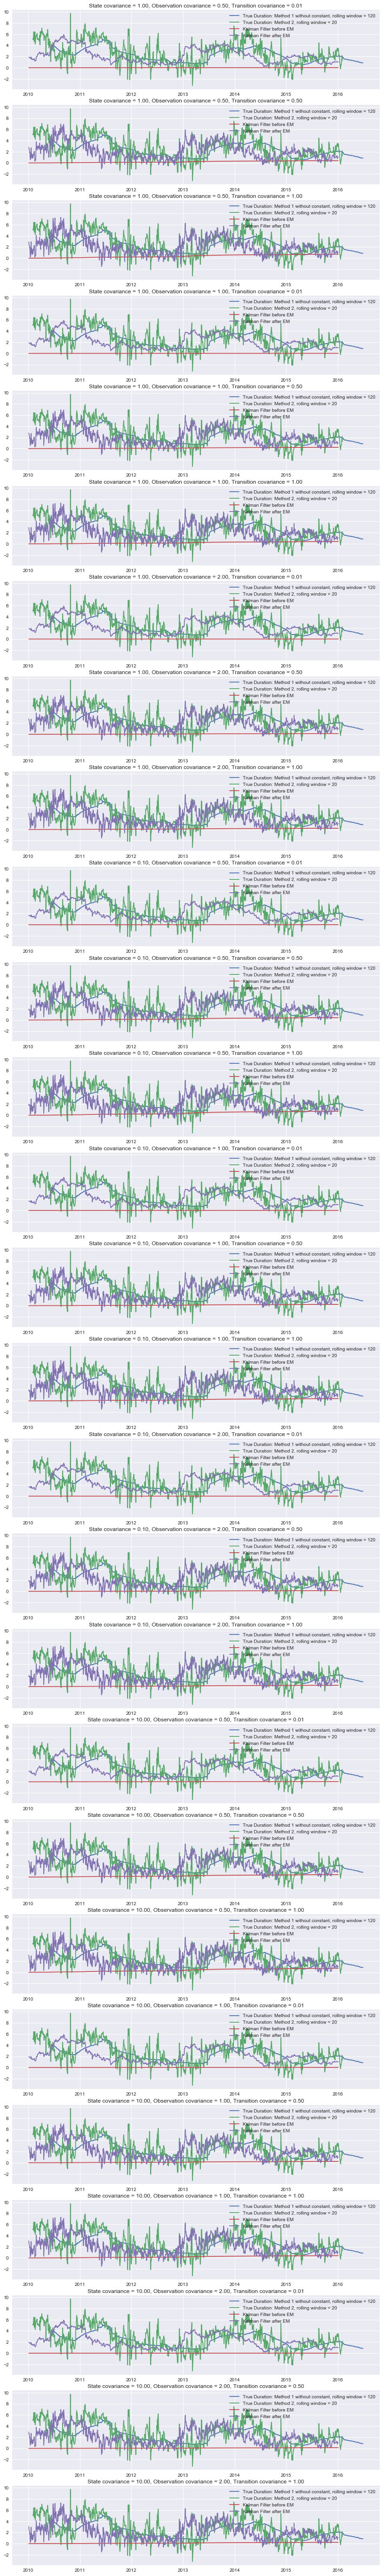

In [23]:
fig = plt.figure(figsize=(14,100))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = d_bf_em_3_5[test_case]
    single_dur_m = d_af_em_3_5[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D_120_woInt[:Total_T].index,np.array(D_120_woInt)[:Total_T], label = \
             'True Duration: Method 1 without constant, rolling window = 120')
    ax.plot(Da2_20.index[:Total_T],np.array(Da2_20)[:Total_T], \
             label = 'True Duration: Method 2, rolling window = 20')
    ax.plot(data.index[:Total_T],np.array(single_dur), label = 'Kalman Filter before EM')
    ax.plot(data.index[:Total_T],np.array(single_dur_m), label = 'Kalman Filter after EM')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], \
                test_case[1], test_case[2]))

## 3.6. MCMC

In [24]:
window = 5
D = []
for t in range(len(delta_r) - window):
    y = ret[t : t+window]
    x = delta_r[t : t+window]
    model = sm.OLS(y, x)
    result = model.fit()
    D.append(- result.params[0])

In [25]:
# MCMC
# Set up pymc3 model object with likelihood
y = ret[:Total_T]
x = delta_r[:Total_T]
model = pm.Model()
with model:
    # alpha and beta coefs
    #sigma_a = pm.HalfNormal('sigma_a',sd=.2)
    #a_t = GaussianRandomWalk('a_t', tau=sigma_a**-1, shape=T)
    sigma_b = pm.HalfNormal('sigma_b',sd=.2)
    b_t = GaussianRandomWalk('b_t', tau=sigma_b**-1, shape=Total_T)
    # Define likelihood
    sigma = pm.HalfNormal('sigma',sd=.2)
    #likelihood = pm.Normal('y', mu=a_t + b_t*x, sd=sigma, observed=y)
    likelihood = pm.Normal('y', mu=b_t*x, sd=sigma, observed=y)

# estimate
# Note: can take a while to run
with model:
    trace = pm.sample(Total_T*2, tune=Total_T)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 8,077.6: 100%|██████████| 200000/200000 [00:57<00:00, 3503.27it/s]
Finished [100%]: Average ELBO = 8,077.5
100%|██████████| 3000/3000 [03:21<00:00, 14.88it/s]


In [26]:
beta_hat = trace.get_values('b_t')
st = pd.DataFrame((pm.stats.df_summary(trace)['mean']))
st = st.ix['b_t__0':'b_t__499']

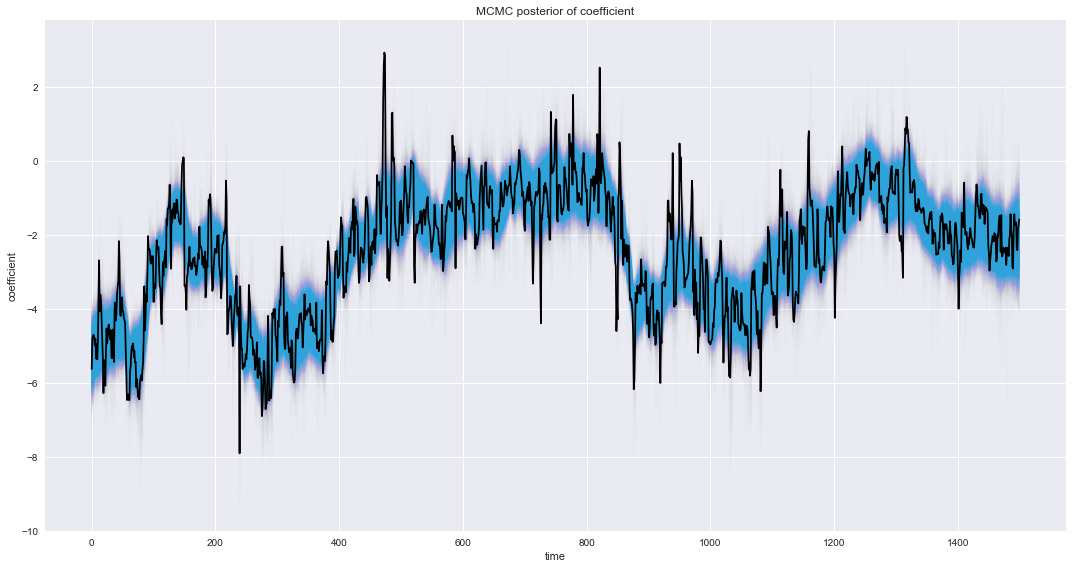

In [27]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(beta_hat.T, alpha=.0025, color='#30a2da');
ax.plot(-np.array(D[:Total_T]), color='k')
ax.set(title='MCMC posterior of coefficient', xlabel='time', ylabel='coefficient');
plt.tight_layout()

# 4. Kalman Filter Result Comparation
For each method, 3 plots are selected.

1) Using parameters corresponding to least correlation between hedged position return using this duration and benchmark interest rate.

For hedging enter swap position as fix payer.

2) Using parameters corresponding to best fit (manual select)

3) Using parameters corresponding to more smooth best fit (manual select)
## 4.1. Kalman Filter for (a): $\frac{\Delta price}{price} = - duration_t * \Delta rate$ 

ISSUE: kalman filter fn will through issue without intercept.

## 4.2. Kalman Filter for (b): $\frac{\Delta price}{price} = - duration_t * \Delta rate + c$

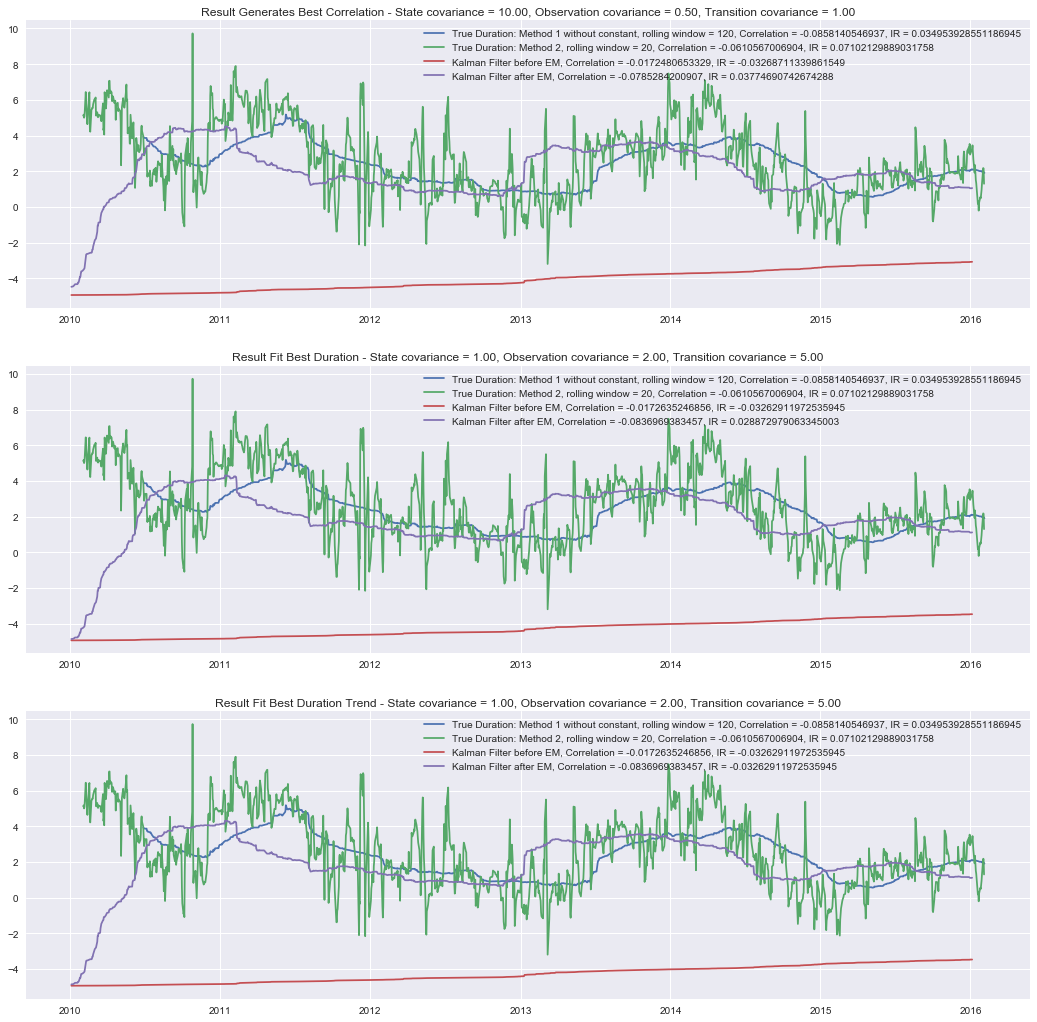

In [28]:
plot_result(data,[d_bf_em_3_2,d_af_em_3_2],['dbem','daem'],tuple([1,2,5]),tuple([1,2,5]),startDate,swp_dur,rate_Base,\
            D_120_woInt[:Total_T+window_20-window_120],window_120,Da2_20[:Total_T],window_20,Total_T,notional,tc_ratio,hedge_frq,c,\
            selection_rule='daem')

## 4.3. Kalman Filter for (c):  $price = \alpha_t + \beta_t * rate$

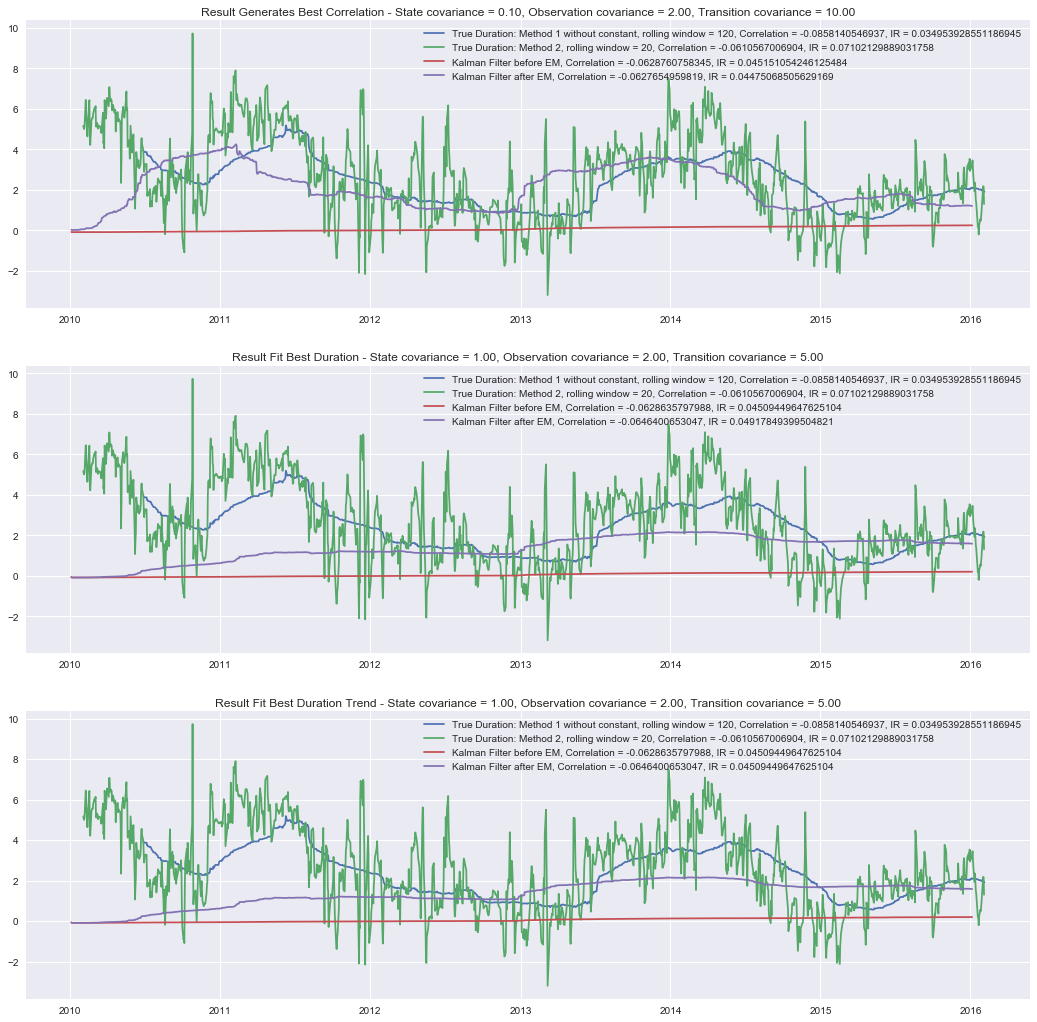

In [29]:
plot_result(data,[d_bf_em_3_3,d_af_em_3_3],['dbem','daem'],tuple([1,2,5]),tuple([1,2,5]),startDate,swp_dur,rate_Base,\
            D_120_woInt[:Total_T+window_20-window_120],window_120,Da2_20[:Total_T],window_20,Total_T,notional,tc_ratio,hedge_frq,c,\
            selection_rule='daem')

## 4.4. Kalman Filter for (d): PCA $price = \alpha_t + \beta_t * rate + \gamma_t * rate^2$


### 4.4.1. PCA Package

-0.0614527499053


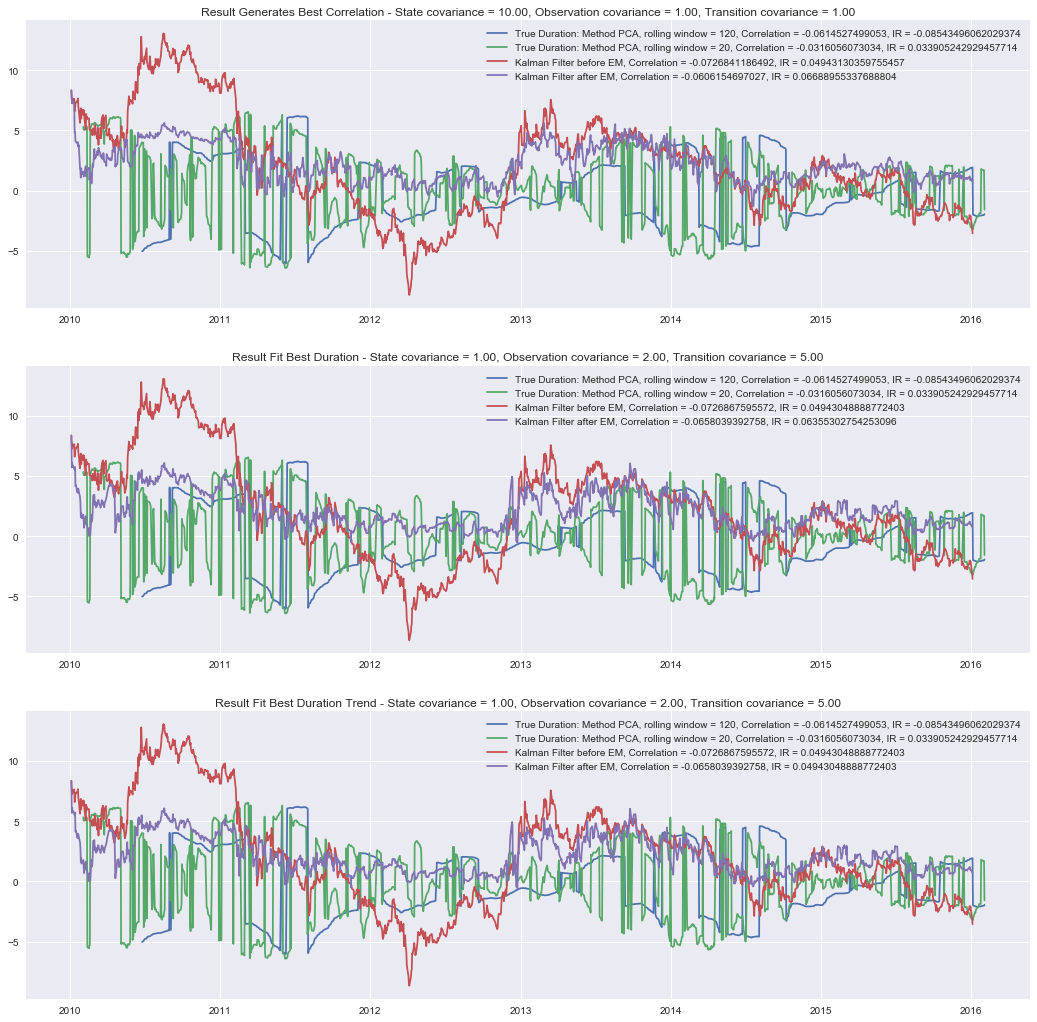

In [30]:
plot_result(data,[d_bf_em_3_4,d_af_em_3_4],['dbem','daem'],tuple([1,2,5]),tuple([1,2,5]),startDate,swp_dur,rate_Base,\
            D3_120_wInt[:Total_T+window_20-window_120],window_120,D3_20_wInt[:Total_T],window_20,Total_T,notional,tc_ratio,hedge_frq,c,\
            selection_rule='daem',if_PCA=True)


### 4.4.2. PCA Self-implementation

KeyError: 'D_120_woInt'

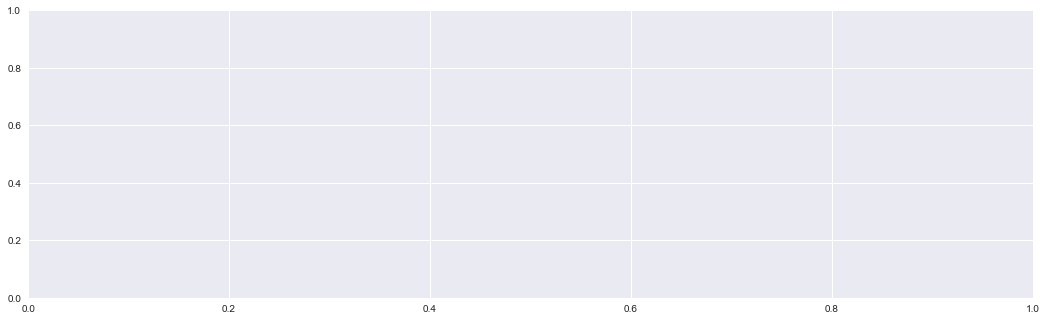

In [31]:
plot_result(data,[d_bf_em_3_4,d_af_em_3_4],['dbem','daem'],tuple([1,2,5]),tuple([1,2,5]),startDate,swp_dur,rate_Base,\
            D3_120_wInt_imp[:Total_T+window_20-window_120],window_120,D3_20_wInt_imp[:Total_T],window_20,Total_T,notional,\
            tc_ratio,hedge_frq,c,\
            selection_rule='daem',if_PCA=True)

## 4.5. Kalman Filter for (e): 
$$\frac{\Delta price}{price} = \beta_1* \Delta rate + \beta_2\beta_1 \cdot r\Delta rate$$

$$Duration = -(\beta_1 + \beta_3 \cdot r)$$


In [ ]:
plot_result(data,[d_bf_em_3_5,d_af_em_3_5],['dbem','daem'],tuple([1,2,5]),tuple([1,2,5]),startDate,swp_dur,rate_Base,\
            D_120_woInt[:Total_T+window_20-window_120],window_120,Da2_20[:Total_T],window_20,Total_T,notional,tc_ratio,hedge_frq,c,\
            selection_rule='daem')